In [11]:
# Import List
import copy

import numpy.array_api
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import *
from sklearn import ensemble, metrics, model_selection, preprocessing

# 实验4

## AdaBoost算法实现

### 数据处理

数据集文件分为train类型和test类型，封装统一的读取数据函数，并输出当前类型下的特征数据和结果数据。

In [12]:
def loadDataSet(fileName):
    # get number of fields
    numFeat = len(open(fileName).readline().split('\t'))
    dataArr = []
    labelArr = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataArr.append(lineArr)
        labelArr.append(float(curLine[-1]))
    return dataArr, labelArr

In [13]:
def get_feature_result(path):
    """
    Args:
        File path   文件路径
    Returns:
        feature 特征标签
        label   分类标签
    """
    data_read = array(pd.read_csv(path)).tolist()
    x = []
    y = []
    for i in range(len(data_read)):
        y.append(data_read[i][-1])
        del data_read[i][-1]
        x.append(data_read[i])

    return array(x), array(y)

In [14]:
def stumpClassify(dataMat, dimen, threshVal, threshIneq):
    """stumpClassify(将数据集，按照feature列的value进行 二分法切分比较来赋值分类)

    Args:
        dataMat    Matrix数据集
        dimen      特征列
        threshVal  特征列要比较的值
    Returns:
        retArray 结果集
    """
    # 默认都是1
    retArray = ones((shape(dataMat)[0], 1))
    # dataMat[:, dimen] 表示数据集中第dimen列的所有值
    # threshIneq == 'lt'表示修改左边的值，gt表示修改右边的值
    # print '-----', threshIneq, dataMat[:, dimen], threshVal
    if threshIneq == 'lt':
        retArray[dataMat[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMat[:, dimen] > threshVal] = -1.0
    return retArray


def buildStump(dataArr, labelArr, D):
    """buildStump(得到决策树的模型)

    Args:
        dataArr   特征标签集合
        labelArr  分类标签集合
        D         最初的样本的所有特征权重集合
    Returns:
        bestStump    最优的分类器模型
        minError     错误率
        bestClasEst  训练后的结果集
    """
    # 转换数据
    dataMat = mat(dataArr)
    labelMat = mat(labelArr).T
    # m行 n列
    m, n = shape(dataMat)

    # 初始化数据
    numSteps = 10.0
    bestStump = {}
    bestClasEst = mat(zeros((m, 1)))
    # 初始化的最小误差为无穷大
    minError = inf

    # 循环所有的feature列，将列切分成 若干份，每一段以最左边的点作为分类节点
    for i in range(n):
        rangeMin = dataMat[:, i].min()
        rangeMax = dataMat[:, i].max()
        # print 'rangeMin=%s, rangeMax=%s' % (rangeMin, rangeMax)
        # 计算每一份的元素个数
        stepSize = (rangeMax-rangeMin)/numSteps
        # 例如:  4=(10-1)/2   那么  1-4(-1次)   1(0次)  1+1*4(1次)   1+2*4(2次)
        # 所以:  循环 -1/0/1/2
        for j in range(-1, int(numSteps)+1):
            # go over less than and greater than
            for inequal in ['lt', 'gt']:
                # 如果是-1，那么得到rangeMin-stepSize; 如果是numSteps，那么得到rangeMax
                threshVal = (rangeMin + float(j) * stepSize)
                # 对单层决策树进行简单分类，得到预测的分类值
                predictedVals = stumpClassify(dataMat, i, threshVal, inequal)
                # print predictedVals
                errArr = mat(ones((m, 1)))
                # 正确为0，错误为1
                errArr[predictedVals == labelMat] = 0
                # 计算 平均每个特征的概率0.2*错误概率的总和为多少，就知道错误率多高
                # 例如:  一个都没错，那么错误率= 0.2*0=0 ， 5个都错，那么错误率= 0.2*5=1， 只错3个，那么错误率= 0.2*3=0.6
                weightedError = D.T*errArr
                '''
                dim            表示 feature列
                threshVal      表示树的分界值
                inequal        表示计算树左右颠倒的错误率的情况
                weightedError  表示整体结果的错误率
                bestClasEst    预测的最优结果
                '''
                # print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError)
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal

    # bestStump 表示分类器的结果，在第几个列上，用大于／小于比较，阈值是多少
    return bestStump, minError, bestClasEst

In [15]:
def adaBoostTrainDS(dataArr, labelArr, numIt=40):
    """adaBoostTrainDS(adaBoost训练过程放大)

    Args:
        dataArr   特征标签集合
        labelArr  分类标签集合
        numIt     实例数
    Returns:
        weakClassArr  弱分类器的集合
        aggClassEst   预测的分类结果值
    """
    weakClassArr = []
    m = shape(dataArr)[0]
    # 初始化 D，设置每行数据的样本的所有特征权重集合，平均分为m份
    D = mat(ones((m, 1))/m)
    aggClassEst = mat(zeros((m, 1)))
    for i in range(numIt):
        # 得到决策树的模型
        bestStump, error, classEst = buildStump(dataArr, labelArr, D)
        # alpha 目的主要是计算每一个分类器实例的权重(加和就是分类结果)
        # 计算每个分类器的 alpha 权重值
        alpha = float(0.5*log((1.0-error)/max(error, 1e-16)))
        bestStump['alpha'] = alpha
        # store Stump Params in Array
        weakClassArr.append(bestStump)

        # print "alpha=%s, classEst=%s, bestStump=%s, error=%s " % (alpha, classEst.T, bestStump, error)
        # 分类正确: 乘积为1，不会影响结果，-1主要是下面求e的-alpha次方
        # 分类错误: 乘积为 -1，结果会受影响，所以也乘以 -1
        expon = multiply(-1*alpha*mat(labelArr).T, classEst)
        # print '\n'
        # print 'labelArr=', labelArr
        # print 'classEst=', classEst.T
        # print '\n'
        # print '乘积: ', multiply(mat(labelArr).T, classEst).T
        # 判断正确的，就乘以-1，否则就乘以1， 为什么？ 书上的公式。
        # print '(-1取反)预测值expon=', expon.T
        # 计算e的expon次方，然后计算得到一个综合的概率的值
        # 结果发现:  判断错误的样本，D对于的样本权重值会变大。
        D = multiply(D, exp(expon))
        D = D/D.sum()
        # print "D: ", D.T
        # print '\n'

        # 预测的分类结果值，在上一轮结果的基础上，进行加和操作
        # print '当前的分类结果: ', alpha*classEst.T
        aggClassEst += alpha*classEst
        # print "叠加后的分类结果aggClassEst: ", aggClassEst.T
        # sign 判断正为1， 0为0， 负为-1，通过最终加和的权重值，判断符号。
        # 结果为: 错误的样本标签集合，因为是 !=,那么结果就是0 正, 1 负
        aggErrors = multiply(sign(aggClassEst) != mat(labelArr).T, ones((m, 1)))
        errorRate = aggErrors.sum()/m
        # print "total error=%s " % (errorRate)
        if errorRate == 0.0:
            break
    return weakClassArr, aggClassEst

模型测试

In [16]:
def adaClassify(datToClass, classifierArr):
    # do stuff similar to last aggClassEst in adaBoostTrainDS
    dataMat = mat(datToClass)
    m = shape(dataMat)[0]
    aggClassEst = mat(zeros((m, 1)))

    # 循环 多个分类器
    for i in range(len(classifierArr)):
        # 前提:  我们已经知道了最佳的分类器的实例
        # 通过分类器来核算每一次的分类结果，然后通过alpha*每一次的结果 得到最后的权重加和的值。
        classEst = stumpClassify(dataMat, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst
        # print aggClassEst
    return sign(aggClassEst)

ROC曲线绘制

In [17]:
def plotROC(predStrengths, classLabels):
    """plotROC(打印ROC曲线，并计算AUC的面积大小)

    Args:
        predStrengths  最终预测结果的权重值
        classLabels    原始数据的分类结果集
    """
    print('predStrengths=', predStrengths)
    print('classLabels=', classLabels)

    import matplotlib.pyplot as plt
    # variable to calculate AUC
    ySum = 0.0
    # 对正样本的进行求和
    numPosClas = sum(array(classLabels)==1.0)
    # 正样本的概率
    yStep = 1/float(numPosClas)
    # 负样本的概率
    xStep = 1/float(len(classLabels)-numPosClas)
    # argsort函数返回的是数组值从小到大的索引值
    # get sorted index, it's reverse
    sortedIndicies = predStrengths.argsort()
    # 测试结果是否是从小到大排列
    print('sortedIndicies=', sortedIndicies, predStrengths[0, 176], predStrengths.min(), predStrengths[0, 293], predStrengths.max())

    # 开始创建模版对象
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    # cursor光标值
    cur = (1.0, 1.0)
    # loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        # draw line from cur to (cur[0]-delX, cur[1]-delY)
        # 画点连线 (x1, x2, y1, y2)
        print(cur[0], cur[0]-delX, cur[1], cur[1]-delY)
        ax.plot([cur[0], cur[0]-delX], [cur[1], cur[1]-delY], c='b')
        cur = (cur[0]-delX, cur[1]-delY)
    # 画对角的虚线线
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    # 设置画图的范围区间 (x1, x2, y1, y2)
    ax.axis([0, 1, 0, 1])
    plt.show()
    '''
    参考说明: http://blog.csdn.net/wenyusuran/article/details/39056013
    为了计算 AUC ，我们需要对多个小矩形的面积进行累加。
    这些小矩形的宽度是xStep，因此可以先对所有矩形的高度进行累加，最后再乘以xStep得到其总面积。
    所有高度的和(ySum)随着x轴的每次移动而渐次增加。
    '''
    print("the Area Under the Curve is: ", ySum*xStep)

[{'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.19299650234767202}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.09649825117383602}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.048249125586918414}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.024124562793458662}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.012062281396729505}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.006031140698365656}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.003015570349182509}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.0015077851745911536}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.000753892587295295}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.0003769462936478035}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.00018847314682377233}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 9.423657341227571e-05}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 4.7118286705566255e-05}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 2.3559143

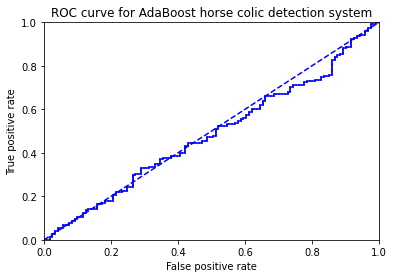

the Area Under the Curve is:  0.4834710743801639
67 20.0 0.29850746268656714


In [18]:
dataArr, labelArr = loadDataSet("horse/horseColicTraining.txt")
weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, labelArr, 40)
print(weakClassArr, '\n-----\n', aggClassEst.T)
# 计算ROC下面的AUC的面积大小
plotROC(aggClassEst.T, labelArr)
# 测试集合
dataArrTest, labelArrTest = loadDataSet("horse/horseColicTest.txt")
m = shape(dataArrTest)[0]
predicting10 = adaClassify(dataArrTest, weakClassArr)
errArr = mat(ones((m, 1)))
# 测试: 计算总样本数，错误样本数，错误率
print(m, errArr[predicting10 != mat(labelArrTest).T].sum(), errArr[predicting10 != mat(labelArrTest).T].sum()/m)

## 随机森林实现

### 数据读取


In [19]:
data = pd.read_csv("Electrical Grid Data.csv")

X = data.drop(['stabf'], axis=1)
y = data['stabf']

sc = preprocessing.StandardScaler()
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=12345)

In [20]:

regression = ensemble.RandomForestClassifier(
    n_estimators=list((50,100,300)),
    max_depth=list((3,5,7,9)),
    criterion=['gini', 'entropy'])
# GridSearchCV调参
gsearsh = model_selection.GridSearchCV(estimator=forest,param_grid=param,n_jobs=-1).fit(x_train, y_train)
# 最优的参数,类型为字典dict
best_param = gsearsh.best_params_
print(best_param)

# 使用经过网格搜索得到的最优参数,n_jobs=-1表示用上所有的处理器
rfc = enumerate.RandomForestClassifier(n_estimators = best_param["n_estimators"],
                            criterion=best_param["criterion"], oob_score=True,n_jobs=-1)
rfc.fit(x_train, y_train)
regression.fit(x_train, y_train)

SyntaxError: invalid syntax (41574562.py, line 8)

In [ ]:
# 输出混淆矩阵封装函数
def confusion_custom(test, pred):
    cnf_matrix = metrics.confusion_matrix(test, pred)
    class_names=[0,1]
    fig, ax = plt.subplots()
    tick_marks = arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # 输出混淆矩阵图
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    # 输出准确度、精确度和召回率
    print("准确率:", metrics.accuracy_score(test, pred))
    # 'micro'：通过计算正确，错误和否定的总数来全局计算指标。
    # 'macro'：计算每个标签的指标，并找到其未加权平均值。这没有考虑标签不平衡。
    print("查准率:", metrics.precision_score(test, pred))
    print("查全率:", metrics.recall_score(test, pred))
    print("F1调和平均值:", metrics.f1_score(test, pred))

# P-R
def pr_display(test, pred):
    precision, recall, _ = metrics.precision_recall_curve(test, pred)
    pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_display.plot()
    plt.show()

# ROC
def roc_display(test, pred):
    fpr, tpr, _ = metrics.roc_curve(test, pred)
    auc = metrics.roc_auc_score(test, pred)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

In [ ]:
y_pred = rtc.predict(x_test).astype(numpy.int64) # 吐槽下网上的解决结果，都没有用新array保存（，直接就是一句.astype，容易踩坑

准确率: 0.9992
查准率: 1.0
查全率: 0.9987437185929648
F1调和平均值: 0.9993714644877436


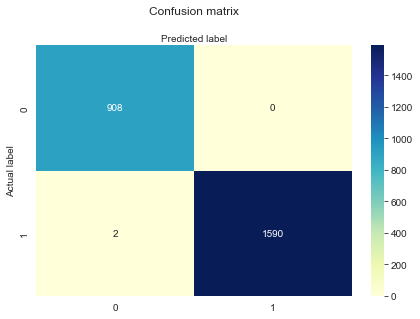

In [ ]:
confusion_custom(y_test, y_pred)

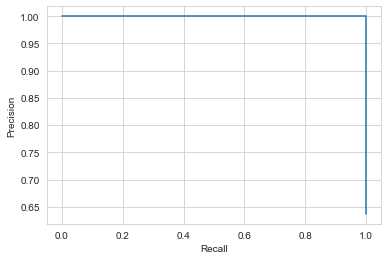

In [ ]:
pr_display(y_test, y_pred)

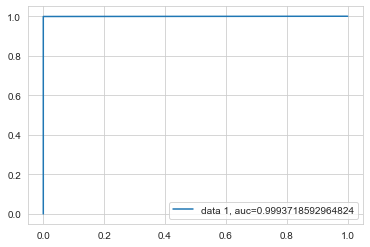

In [ ]:
roc_display(y_test, y_pred)